In [1]:
library(tidyverse)
library(yaml)
library(rstan)
library(tidybayes)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: StanHeaders


rstan version 2.32.3 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
chan

## Config and data

In [2]:
config_id <- "pooling_sim_partial_pool"
data_config_id <- "pooling_sim"

In [3]:
data_config <- yaml.load_file(paste0("../data/configs/", data_config_id, "/data.yaml"))
main_config <- yaml.load_file(paste0("../experiments/configs/", config_id, "/main.yaml"))

In [4]:
results_base_dir <- paste0("../experiments/results/", config_id)
if (!dir.exists(results_base_dir)) {
    dir.create(results_base_dir, recursive = TRUE)
}

### Data

In [5]:
data_base_dir <- paste0("../", data_config$output_dir)
data_path <- paste0(data_base_dir, "/data.csv")
beta_0 <- data_config$beta_0
beta_1 <- data_config$beta_1
n_measurements <- data_config$n_measurements

In [6]:
data_df <- read_csv(data_path)
fit_data_df <- data_df %>%
    filter(measurement_id < n_measurements)
eval_data_df <- data_df %>%
    filter(measurement_id == n_measurements)

Rows: 1500 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (8): group_id, group_effect, x, indiv_effect, indiv_id, measurement_id, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Model

In [7]:
model_seed <- main_config$seed
n_samp <- main_config$n_samp
n_warmup_samp <- main_config$n_warmup_samp
n_chains <- main_config$n_chains
model_file_path <- paste0("../", main_config$model_file_path)

## Model fitting

Note that we are only doing "no pooling" for the intercept. We assume a fixed slope.

In [8]:
n_indiv = eval_data_df %>% distinct(indiv_id) %>% nrow()
n_groups = eval_data_df %>% distinct(group_id) %>% nrow()

In [9]:
stan_data <- list(
    N = eval_data_df %>% nrow(),
    n_indiv = n_indiv,
    n_groups = n_groups,
    y = eval_data_df %>% pull(y),
    x = eval_data_df %>% pull(x),
    indiv_id = eval_data_df %>% pull(indiv_id),
    group_id_map = eval_data_df %>%
        distinct(indiv_id, group_id) %>%
        arrange(indiv_id) %>%
        pull(group_id),
    beta_0_mu_group_prior = rep(beta_0, n_groups),
    beta_0_sigma_indiv_prior = 5.0,
    beta_0_sigma_group_prior = 5.0,
    beta_1_sigma_prior = 1.0
)

In [10]:
if (!file.exists(paste0(results_base_dir, "/fit.rds"))) {
    fit <- stan(
        file = model_file_path,
        data = stan_data,
        chains = n_chains,
        iter = n_samp,
        warmup = n_warmup_samp,
        seed = model_seed,
        cores = n_chains,
        pars = c("beta_0", "beta_1"),
        include = TRUE
    )
    saveRDS(fit, paste0(results_base_dir, "/fit.rds"))
    
    tidy_draws_df <- fit %>% tidybayes::spread_draws(beta_0[i], beta_1)
    tidy_draws_df %>%
        write_csv(paste0(results_base_dir, "/draws.csv"))
} else {
    fit <- readRDS(paste0(results_base_dir, "/fit.rds"))
    tidy_draws_df <- read_csv(paste0(results_base_dir, "/draws.csv"))
}

Warning message:
“There were 124 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 6 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.4, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https:

In [11]:
tidy_draws_long_df <- tidy_draws_df %>%
    pivot_longer(cols = !c(".chain", ".iteration", ".draw", "i"), names_to = "param") %>%
    ungroup() %>%
    rename(indiv_id = i)

In [12]:
fit_summary <- summary(fit)

In [13]:
fit_summary$summary %>%
    as_tibble(rownames = "param") %>%
    filter(param == "beta_1")

param,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
beta_1,0.9476043,0.02295564,0.1577216,0.6506411,0.8475191,0.9382217,1.035152,1.300041,47.20667,1.103519


In [14]:
fit_summary$summary %>%
    as_tibble(rownames="param") %>%
    arrange(desc(Rhat)) %>%
    filter(str_starts(param, "beta_0")) %>%
    summarize(
        Rhat_min = min(Rhat),
        Rhat_max = max(Rhat),
        Rhat_mean = mean(Rhat)
    )

Rhat_min,Rhat_max,Rhat_mean
<dbl>,<dbl>,<dbl>
0.9992621,1.090242,1.046302


In [15]:
set_theme_elements <- function(plt) {
    plt +
        theme_classic() +
        theme(text = element_text(size=16))
}

# Settings for plots
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 100)

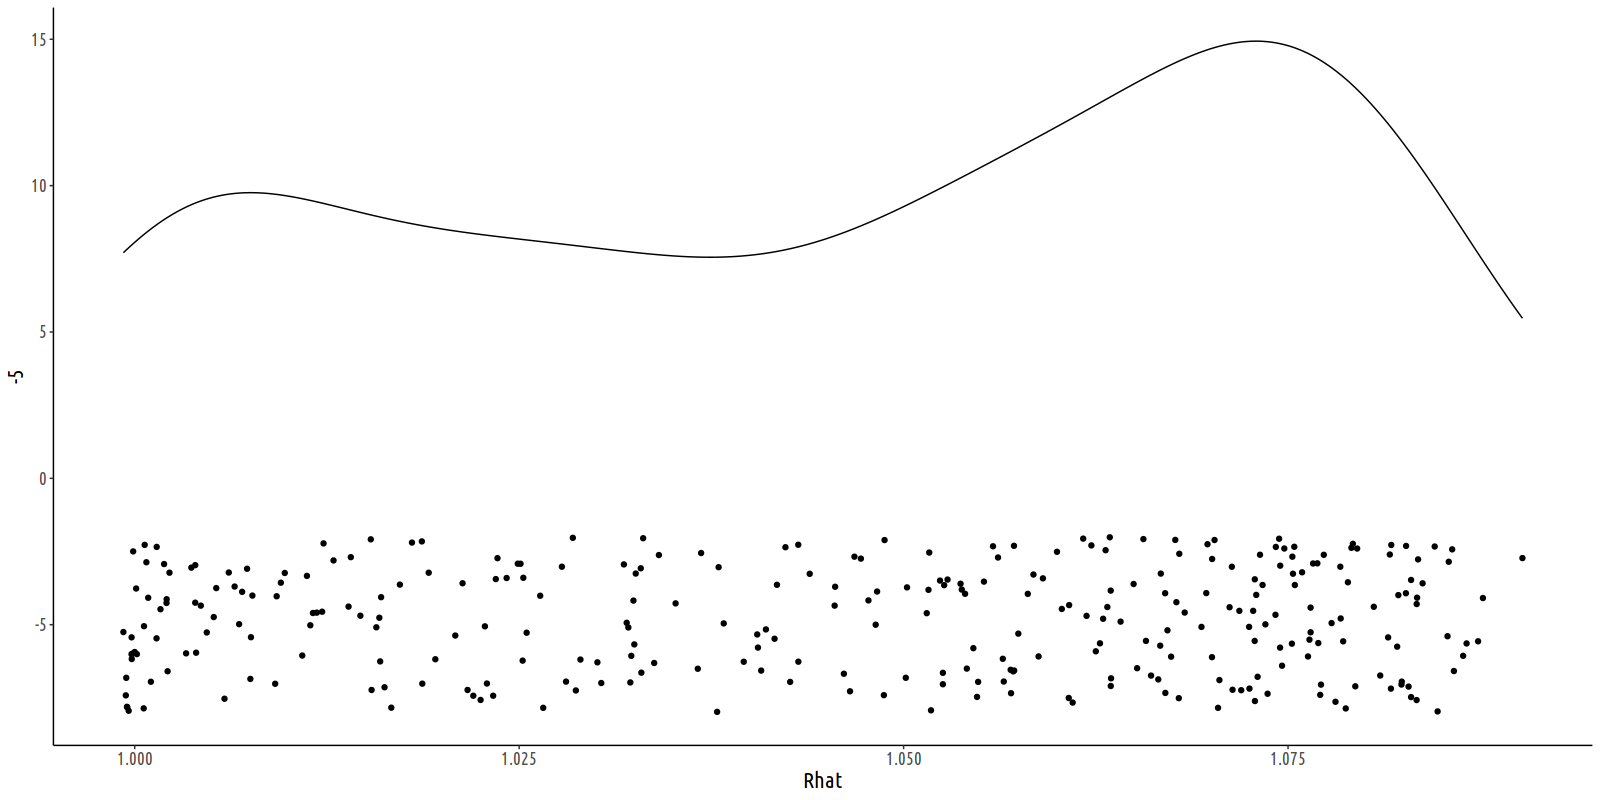

In [16]:
# TODO: improve this plot

plt <- fit_summary$summary %>%
    as_tibble(rownames="param") %>%
    arrange(desc(Rhat)) %>%
    filter(str_starts(param, "beta_0")) %>%
    ggplot() +
    geom_density(aes(x = Rhat)) +
    geom_jitter(aes(x = Rhat, y = -5), width = 0, height = 3)
plt <- plt %>%
    set_theme_elements()
plt

In [17]:
post_predictions <- function(samp_df, x_df, n_post = 100) {
    # Perform sampling of beta_0 separately for all individuals 
    # since there is no pooling for this parameter
    beta_0_df <- samp_df %>%
        group_by(indiv_id, param) %>%
        slice_sample(n = n_post, replace = TRUE) %>%
        mutate(sample_id = 1:n()) %>%
        ungroup() %>%
        pivot_wider(id_cols = c("indiv_id", "sample_id"), names_from = "param", values_from = "value") %>%
        rename(betahat_0 = beta_0, betahat_1 = beta_1) %>%
        # # Use many-to-many if there are multiple measurements per individual
        # # in the evaluation set
        # inner_join(x_df, by = "indiv_id", relationship = "many-to-many") %>%
        inner_join(x_df, by = "indiv_id") %>%
        mutate(yhat = betahat_0 + betahat_1 * x)

    # Perform sampling of beta_1 jointly for all individuals
    # since this parameter is fully pooled
    beta_1_df <- samp_df %>%
        filter(param == "beta_1") %>%
        select(-c(indiv_id)) %>%
        distinct() %>%
        slice_sample(n = n_post, replace = TRUE) %>%
        mutate(sample_id = 1:n()) %>%
        pivot_wider(id_cols = c("sample_id"), names_from = "param", values_from = "value")

    beta_0_df %>%
        inner_join(beta_1_df, by = "sample_id")
}

In [18]:
df <- eval_data_df %>%
    select(
        indiv_id,
        x,
        y
    )

In [19]:
preds_df <- post_predictions(tidy_draws_long_df, df, n_post = 100)

In [20]:
preds_df %>%
    mutate(
        se = (y - yhat)^2,
        resid = y - yhat
    ) %>%
    summarize(
        rmse = sqrt( mean(se) ),
        mean_resid = mean( abs(resid) )
    )

rmse,mean_resid
<dbl>,<dbl>
0.7440903,0.5469708
